In [2]:
import torch
from torchvision import transforms, datasets, models
from torch import nn, optim, functional
from torch.utils import data
from torchsummary import summary
from torch.utils.data import random_split, Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import os
import random
from PIL import Image
from math import ceil

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
params ={
    "batch_size" : 32,
    "epoch" : 20,
    "device": device,
    
}

In [4]:
#check num class
classes = {
    "FAKE" : 0,
    "REAL" : 1
}
id2label = {v: k for k, v in classes.items()}

# Pre-Processing

In [5]:
train_dir = "Dataset/train"
test_dir = "Dataset/test"

In [6]:
FAKE_view = [train_dir + '/FAKE/' + img for img in os.listdir(train_dir + '/FAKE')[:9]]
REAL_view = [train_dir + '/REAL/' + img for img in os.listdir(train_dir + '/REAL')[:9]]

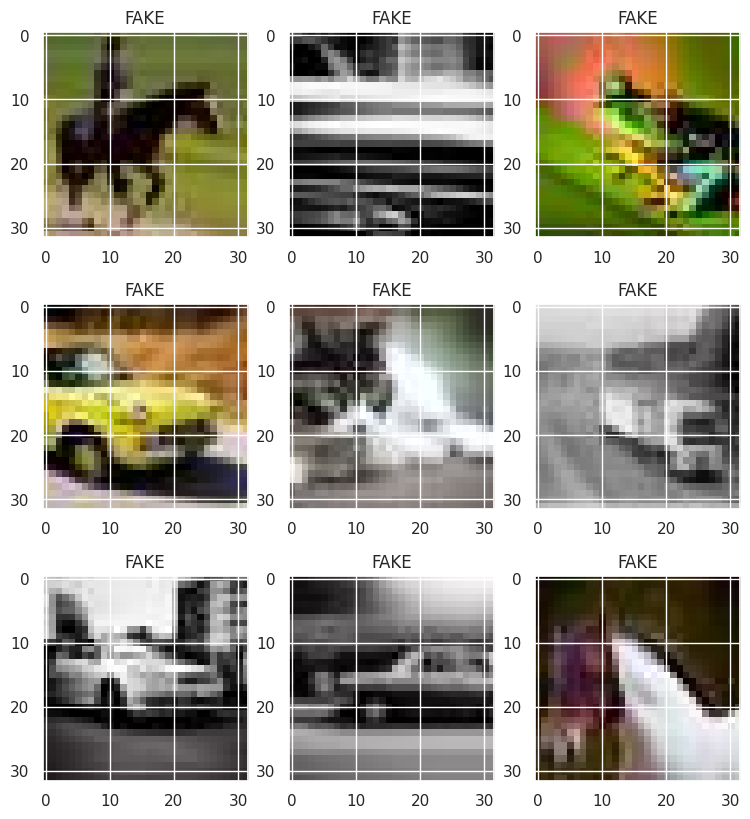

In [7]:
# FAKE CLASS
plt.figure(figsize=(9,10))
for i,k  in enumerate(FAKE_view):
    image = Image.open(k)
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title("FAKE")

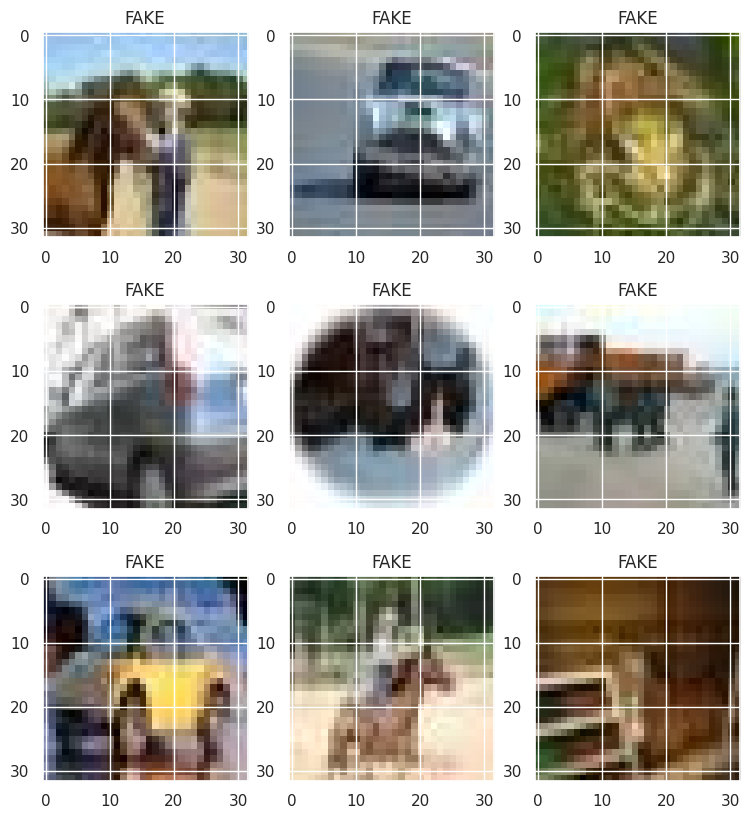

In [8]:
# REAL CLASS
plt.figure(figsize=(9,10))
for i,k  in enumerate(REAL_view):
    image = Image.open(k)
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.title("FAKE")

In [9]:
class CifakeDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        super(CifakeDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir, name))
            self.data += list(zip(files, [index] * len(files)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_file, label = self.data[index]
        root_and_dir = os.path.join(self.root_dir, self.class_names[label])
        image = np.array(Image.open(os.path.join(root_and_dir, img_file)))

        if self.transform is not None:
            augmentations = self.transform(image=image)
            image = augmentations["image"]

        return image, label

## Data Augmentation

In [10]:
train_transform = A.Compose([
    A.Resize(32,32),
    A.RandomRotate90(p=0.2),
    A.Flip(p=0.2),
    A.GaussNoise(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.RandomBrightnessContrast(),            
    ], p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(32,32),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
]) 

In [11]:
train_dataset = CifakeDataset(train_dir, train_transform)
val_dataset = CifakeDataset(train_dir, test_transform)
test_dataset = CifakeDataset(test_dir, test_transform)

## Split Dataset

In [12]:
num_train = len(train_dataset)
indices = list(range(num_train))
train_count = int(0.8*num_train)
valid_count = num_train - train_count
train_idx = indices[:train_count]
valid_idx = indices[train_count:]
# Check Len
print("Training Size\t:", train_count)
print("Validation Size\t:", valid_count)
print("Test Size\t:", len(test_dataset))

Training Size	: 80000
Validation Size	: 20000
Test Size	: 20000


In [13]:
# Create Sampler for train dataset and valid dataset
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [14]:
def show_image(train_dataset=train_dataset, inline=4):
    plt.figure(figsize=(8,4))
    for i in range(inline):
        rand = random.randint(0, len(train_dataset))
        image, label = train_dataset[rand]
        plt.subplot(1, inline, i%inline +1)
        plt.axis('off')
        plt.imshow(image.permute(2, 1, 0))
        plt.title(f'{id2label[label]}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

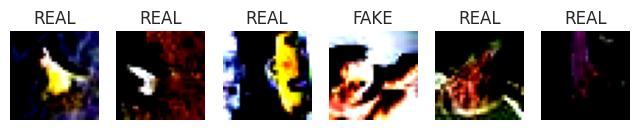

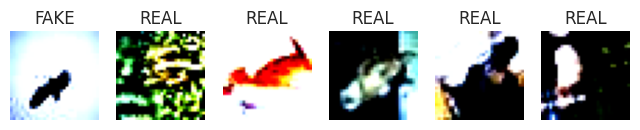

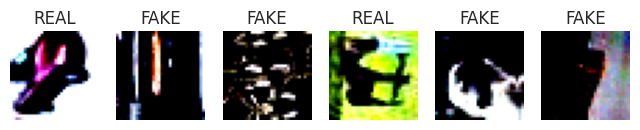

In [15]:
for i in range(3):
    show_image(inline=6)

In [16]:
# Define data loader
batch_size = params['batch_size']
train_loader = DataLoader(train_dataset, batch_size*2, sampler = train_sampler, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, sampler = valid_sampler, pin_memory=True )
test_loader = DataLoader(test_dataset, batch_size,shuffle= False, pin_memory=True)

# Modeling

In [17]:
import time

In [18]:
def load_latest_model(model, name="model.pt"):
    """
    Helper function for Load model
    :param model: current model
    :param name: model name
    :return: loaded model default model.pt
    """
    model.load_state_dict(torch.load(name))
    return model

def train(model, train_loader, test_loader,
          epochs, optimizer, criterion, scheduler=None,
          name="model.pt", path=None):
    """
    Helper function for train model
    :param model: current model
    :param train_loader: train data loader
    :param test_loader: test data loader
    :param epochs: number of epoch
    :param optimizer: optimizer
    :param criterion: loss function
    :param scheduler: scheduler, default None
    :param name: model name, default model.pt
    :param path: model saved location, default None
    :return: model, list of train loss and test loss
    """

    # compare overfitted
    train_loss_data, valid_loss_data = [], []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for epoch in range(epochs):
        print("Epoch: {}/{}".format(epoch + 1, epochs))
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        correct = 0
        e_since = time.time()

        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        if scheduler is not None:
            scheduler.step()  # step up scheduler

        for images, labels in train_loader:
            # Move input and label tensors to the default device
            images, labels = images.to(device), labels.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            log_ps = model(images).to(device)
            # calculate the loss
            loss = criterion(log_ps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * images.size(0)

        ######################
        # validate the model #
        ######################
        print("\t\tGoing for validation")
        model.eval()  # prep model for evaluation
        for data, target in test_loader:
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss_p = criterion(output, target)
            # update running validation loss
            valid_loss += loss_p.item() * data.size(0)
            # calculate accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)
            # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(test_loader.dataset)

        # calculate train loss and running loss
        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)

        print("\tTrain loss:{:.6f}..".format(train_loss),
              "\tValid Loss:{:.6f}..".format(valid_loss),
              "\tAccuracy: {:.4f}".format(correct / total * 100))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            torch.save(model.state_dict(), name)
            valid_loss_min = valid_loss
            # save to google drive
            if path is not None:
                torch.save(model.state_dict(), path)

        # Time take for one epoch
        time_elapsed = time.time() - e_since
        print('\tEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    # compare total time
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model
    model = load_latest_model(model, name)

    # return the model
    return [model, train_loss_data, valid_loss_data]

In [19]:
def check_overfitted(train_loss, test_loss):
    """
    Helper function for check over fitting
    :param train_loss: list of train loss
    :param test_loss: list of test loss
    :return: None
    """
    fig = plt.figure()
    plt.plot(train_loss, label="Training loss")
    plt.plot(test_loss, label="validation loss")
    plt.legend()

In [20]:
def test_per_class(model, test_loader, criterion, classes):
    """
    Helper function for testing per class
    :param model: current model
    :param test_loader: test loader
    :param criterion: loss function
    :param classes: list of classes
    :return: None
    """

    total_class = len(classes)

    test_loss = 0.0
    class_correct = list(0. for i in range(total_class))
    class_total = list(0. for i in range(total_class))
    # calculate time
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()  # prep model for evaluation
    print("Starting Test Per Class......\n")
    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(len(target) - 1):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        

    # calculate and print avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(total_class):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    # compare total time
    time_elapsed = time.time() - since
    print('Test Per Class completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

In [21]:
def overall_test(model, test_loader, criterion):
    # calculate time
    since = time.time()
    print(".................Starting Overall Test.................")
    test_loss= 0
    all_preds = []
    all_targets = []
    accuracy = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            
            if criterion is not None:
                batch_loss = criterion(logps, labels)
                test_loss += batch_loss.item()

            # Calculate accuracy
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            all_preds.append(top_class.unsqueeze(-1))
            all_targets.append(labels.view(*top_class.shape).unsqueeze(-1))
            
    if criterion is not None:
        print("Test Loss:{:.6f}".format(test_loss),
              "\nAccuracy: {:.4f}".format(accuracy / len(test_loader) * 100))
    else:
        print("Accuracy: {:.4f}".format(accuracy / len(test_loader) * 100))
    # compare total time
    time_elapsed = time.time() - since
    print('Overall Test completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    return [all_preds,all_targets]

In [22]:
def displayCM(all_preds, all_targets):
    preds = torch.cat(all_preds).squeeze(-1).cpu()
    targets = torch.cat(all_targets).squeeze(-1).cpu()
    #Plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.grid(False)

    labels = list(classes)
    cm = confusion_matrix(targets, preds, normalize='true')
    cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
    cm_display.plot(ax=ax, xticks_rotation=35.0)
    return [preds, targets,labels]

## EfficientNet From Scratch

In [23]:
# ConvBlock
class ConvBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, stride, padding, groups=1):
        super(ConvBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()  # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

In [24]:
# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SEBlock, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

In [25]:
# MBConv
class MBConv(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        expand_ratio,
        reduction=4,  # squeeze excitation
        survival_prob=0.8,  # for stochastic depth
    ):
        super(MBConv, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = ConvBlock(
                in_channels,
                hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1,
            )

        self.conv = nn.Sequential(
            ConvBlock(
                hidden_dim,
                hidden_dim,
                kernel_size,
                stride,
                padding,
                groups=hidden_dim,
            ),
            SEBlock(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = (
            torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        )
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)

In [26]:
class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha**phi
        width_factor = beta**phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [ConvBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4 * ceil(int(channels * width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    MBConv(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride=stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2,  # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            ConvBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))

In [27]:
base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [28]:
version = "b4"
phi, res, drop_rate = phi_values[version]
model = EfficientNet(version, num_classes=2).to(params['device'])

In [29]:
model

EfficientNet(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (features): Sequential(
    (0): ConvBlock(
      (cnn): Conv2d(3, 42, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (silu): SiLU()
    )
    (1): MBConv(
      (conv): Sequential(
        (0): ConvBlock(
          (cnn): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=42, bias=False)
          (bn): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (silu): SiLU()
        )
        (1): SEBlock(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(42, 10, kernel_size=(1, 1), stride=(1, 1))
            (2): SiLU()
            (3): Conv2d(10, 42, kernel_size=(1, 1), stride=(1, 1))
            (4): Sigmoid()
          )
        )
        (2): Conv2d(42, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [30]:
last_layer = nn.Sequential(
  nn.Dropout(0.4),
  nn.Linear(in_features=1704, out_features=1792),
  nn.Linear(in_features=1792, out_features=2)
)
    
model.classifier = last_layer
model.to(params['device'])

EfficientNet(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (features): Sequential(
    (0): ConvBlock(
      (cnn): Conv2d(3, 42, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (silu): SiLU()
    )
    (1): MBConv(
      (conv): Sequential(
        (0): ConvBlock(
          (cnn): Conv2d(42, 42, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=42, bias=False)
          (bn): BatchNorm2d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (silu): SiLU()
        )
        (1): SEBlock(
          (se): Sequential(
            (0): AdaptiveAvgPool2d(output_size=1)
            (1): Conv2d(42, 10, kernel_size=(1, 1), stride=(1, 1))
            (2): SiLU()
            (3): Conv2d(10, 42, kernel_size=(1, 1), stride=(1, 1))
            (4): Sigmoid()
          )
        )
        (2): Conv2d(42, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
  

In [31]:
criterion = nn.CrossEntropyLoss()
optimizerAdam = optim.Adam(model.parameters(), lr=1e-3)
optimizerSGD = optim.SGD(model.parameters(),lr=1e-3, momentum=0.9)

In [32]:
epoch = params["epoch"]
model, train_loss, test_loss = train(model, train_loader, val_loader, epoch, optimizerSGD, criterion)

Epoch: 1/20
		Going for validation
	Train loss:0.468488.. 	Valid Loss:0.116316.. 	Accuracy: 73.5050
	Validation loss decreased (inf --> 0.116316).  Saving model ...
	Epoch:1 completed in 2m 29s
Epoch: 2/20
		Going for validation
	Train loss:0.347373.. 	Valid Loss:0.089934.. 	Accuracy: 78.8700
	Validation loss decreased (0.116316 --> 0.089934).  Saving model ...
	Epoch:2 completed in 2m 30s
Epoch: 3/20
		Going for validation
	Train loss:0.300787.. 	Valid Loss:0.096741.. 	Accuracy: 77.3750
	Epoch:3 completed in 2m 29s
Epoch: 4/20
		Going for validation
	Train loss:0.275227.. 	Valid Loss:0.059914.. 	Accuracy: 86.7750
	Validation loss decreased (0.089934 --> 0.059914).  Saving model ...
	Epoch:4 completed in 2m 29s
Epoch: 5/20
		Going for validation
	Train loss:0.260289.. 	Valid Loss:0.056671.. 	Accuracy: 89.1100
	Validation loss decreased (0.059914 --> 0.056671).  Saving model ...
	Epoch:5 completed in 2m 31s
Epoch: 6/20
		Going for validation
	Train loss:0.245561.. 	Valid Loss:0.061073..

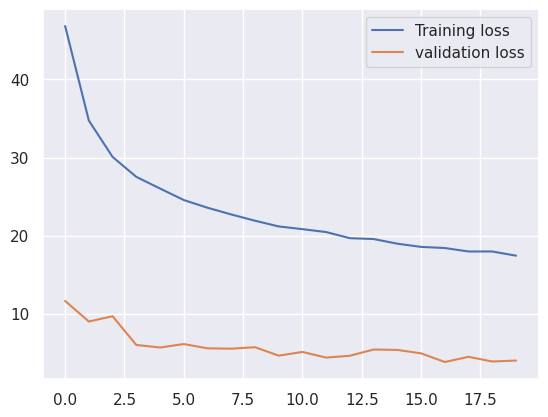

In [33]:
check_overfitted(train_loss, test_loss)

In [34]:
test_per_class(model, test_loader, criterion, classes)

Starting Test Per Class......

Test Loss: 0.166501

Test Accuracy of     0: 94% (9162/9688)
Test Accuracy of     1: 93% (9037/9687)

Test Accuracy (Overall): 93% (18199/19375)
Test Per Class completed in 0m 26s


In [35]:
all_preds, all_targets = overall_test(model, test_loader, criterion)

.................Starting Overall Test.................
Test Loss:104.063030 
Accuracy: 93.9150
Overall Test completed in 0m 25s


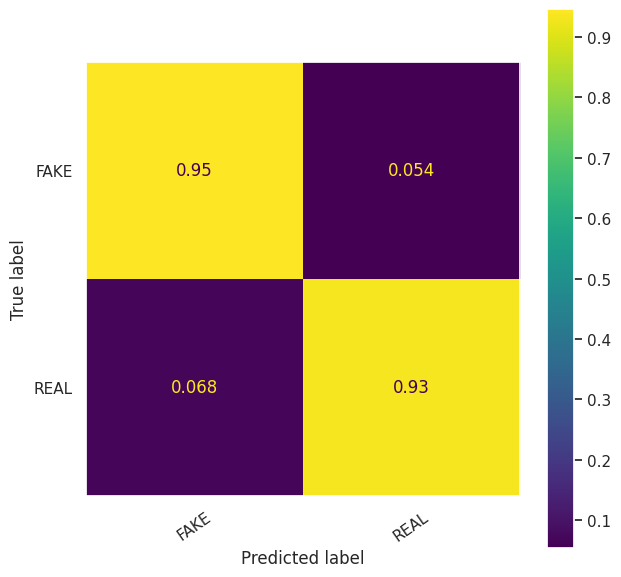

In [36]:
preds, targets, labels= displayCM(all_preds, all_targets)

In [37]:
# Classification Report
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

        FAKE       0.93      0.95      0.94     10000
        REAL       0.95      0.93      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



## EfficientNet Pretrained

In [21]:
model_pretrained = models.efficientnet_b4()
model_pretrained.to(params['device'])

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [22]:
last_layer = nn.Sequential(
    nn.Dropout(p=0.4, inplace=False),
    nn.Linear(in_features=1792, out_features=2, bias=True)
)
model_pretrained.classifier = last_layer
model_pretrained.to(params['device'])

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [25]:
criterion = nn.CrossEntropyLoss()
optimizerAdam_pretrained = optim.Adam(model_pretrained.parameters(), lr = 1e-3)
optimizerSGD_pretrained = optim.SGD(model_pretrained.parameters(), lr=1e-3, momentum= 0.9)

In [27]:
epoch = params["epoch"]
model_pretrained, train_loss_pretrained, test_loss_pretrained = train(model_pretrained, train_loader, val_loader, epoch, optimizerSGD_pretrained, criterion, name='model_pretrained.pt')

Epoch: 1/20
		Going for validation
	Train loss:0.514408.. 	Valid Loss:0.187284.. 	Accuracy: 24.6850
	Validation loss decreased (inf --> 0.187284).  Saving model ...
	Epoch:1 completed in 2m 43s
Epoch: 2/20
		Going for validation
	Train loss:0.466742.. 	Valid Loss:0.161147.. 	Accuracy: 41.9800
	Validation loss decreased (0.187284 --> 0.161147).  Saving model ...
	Epoch:2 completed in 2m 42s
Epoch: 3/20
		Going for validation
	Train loss:0.437320.. 	Valid Loss:0.163857.. 	Accuracy: 42.4400
	Epoch:3 completed in 2m 44s
Epoch: 4/20
		Going for validation
	Train loss:0.414178.. 	Valid Loss:0.159936.. 	Accuracy: 53.8550
	Validation loss decreased (0.161147 --> 0.159936).  Saving model ...
	Epoch:4 completed in 2m 46s
Epoch: 5/20
		Going for validation
	Train loss:0.396225.. 	Valid Loss:0.137541.. 	Accuracy: 60.6800
	Validation loss decreased (0.159936 --> 0.137541).  Saving model ...
	Epoch:5 completed in 2m 43s
Epoch: 6/20
		Going for validation
	Train loss:0.377879.. 	Valid Loss:0.133336..

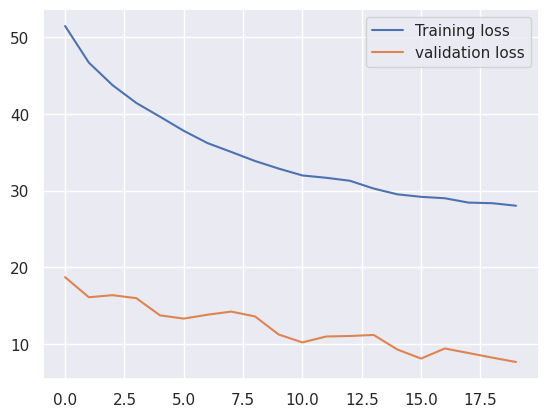

In [29]:
check_overfitted(train_loss_pretrained, test_loss_pretrained)

In [30]:
test_per_class(model_pretrained, test_loader, criterion, classes)

Starting Test Per Class......

Test Loss: 0.276560

Test Accuracy of     0: 95% (9208/9688)
Test Accuracy of     1: 84% (8147/9687)

Test Accuracy (Overall): 89% (17355/19375)
Test Per Class completed in 0m 17s


In [31]:
all_preds, all_targets = overall_test(model_pretrained, test_loader, criterion)

.................Starting Overall Test.................
Test Loss:172.850069 
Accuracy: 89.5200
Overall Test completed in 0m 14s


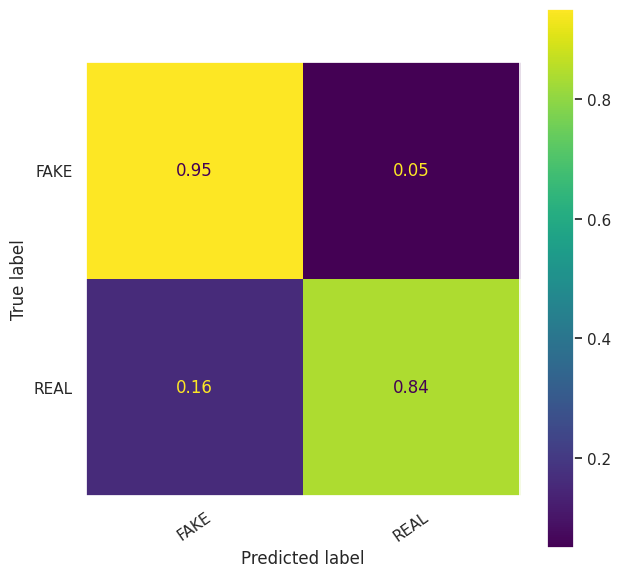

In [32]:
preds, targets, labels= displayCM(all_preds, all_targets)

In [33]:
# Classification Report
print(classification_report(targets, preds, target_names=labels, zero_division=0))

              precision    recall  f1-score   support

        FAKE       0.86      0.95      0.90     10000
        REAL       0.94      0.84      0.89     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.89     20000
weighted avg       0.90      0.90      0.89     20000

